In [1]:
import numpy as np
import pandas as pd
import os
import math
from itertools import combinations as comb
import matplotlib as plt
from shapely.geometry import LineString
from shapely.geometry import Point, Polygon

#### 根据TTC结果提取其中的时间链

In [3]:
# 对冲突类型进行分类，这边保留碰撞对象中涉及机动车的所有事故
def Extract_conflict_relate_car(conflcit_envent_data_file):
    df = pd.read_csv(conflcit_envent_data_file)
    df = pd.DataFrame(df)
    #  提取其中一辆车是机动车的交互事件
    interfere_motorveh = df[(df['F_vehicle_type'] == " Car") | (df['S_vehicle_type'] == " Car")]
    return interfere_motorveh

In [4]:
# 对数据进行重定义，筛选dataframe列表中第一辆车的类型不是car的所有行对应的列表，再调换新列表中第一辆车信息与第二辆车信息。
def Restructure_data_TTC(interfere_motor_vehicle,Columns_name):
    df = pd.DataFrame(interfere_motor_vehicle)
    df_first_car = df[df['F_vehicle_type']==" Car"]
    df_first_no_car = df[df['F_vehicle_type']!=" Car"]
    new_df_first_no_car = df_first_no_car.reset_index(drop=True)
    columnss = new_df_first_no_car.columns.tolist()
    # 这边必须是：间隔
    new_columns = columnss[12:13] + columnss[1:2]+ columnss[13:23]+columnss[0:1]+columnss[2:12] + columnss[23:26]
    df_new_no_car_first = new_df_first_no_car[new_columns]
    df_new_no_car_first.columns.name = None
#     df_new_no_car_first_T = df_new_no_car_first.rename(columns=dict(zip(df.columns, Columns_name)), inplace=False)
    df_new_no_car_first.columns = Columns_name
    New_df = pd.concat([df_first_car,df_new_no_car_first])
    return New_df

In [5]:
#提取事件链条
def Extract_event_by_ttc(envent_data,colmun_name):
    # create a empty matrix , save the conflict event chain
    Event_veh_pairs = []
    Event_veh_pairs_chain = pd.DataFrame(columns=colmun_name)
    # replace the value moreover than 1000 by nan
    envent_data.loc[envent_data['TTC'] >= 10000, 'TTC'] = np.nan
    # acquire the veh pair
    veh_pairs = envent_data[['F_vehicle_id','S_vehicle_id']]
    # delete the repeat row
    veh_pairs_unique = veh_pairs.drop_duplicates()
    # extract the veh pairs
    pairs = list(zip(veh_pairs_unique['F_vehicle_id'], veh_pairs_unique['S_vehicle_id']))
    for id in pairs:
        conflict_env = envent_data[(envent_data['F_vehicle_id'] == id[0]) & (envent_data['S_vehicle_id'] == id[1])]
        # delete the no TTC value <10
        has_not_nan = conflict_env['TTC'].notna().any()
        if (has_not_nan==True):
            all_greater_than_10 = (conflict_env['TTC'] >= 10).all() # 判断是否所有的TTC值都是大于10的
            if (all_greater_than_10==False):
                # 基于现有的TTC结果提取数据质量相对较好的过程数据，设置一些具体的限制条件
                    #第一，存在TTC数值小于2秒的点
                    #第二，存在TTC数值小于5秒的点的数量不少于1秒，也就是不少于25个点
                conflict_env.loc[conflict_env['TTC'] >= 10, 'TTC'] = 10
                min_ttc = min(conflict_env['TTC'])
                N_ttc_low_5 = len(conflict_env[conflict_env["TTC"]<=5])
#                 print(min_ttc,N_ttc_low_5)
                if (min_ttc<=2) and(N_ttc_low_5>=5):
                    conflict_env_chain = envent_data[(envent_data['F_vehicle_id'] == id[0]) & (envent_data['S_vehicle_id'] == id[1])]
                    Event_veh_pairs_chain = pd.concat([Event_veh_pairs_chain,conflict_env_chain])
                    Event_veh_pairs.append(id)
    return Event_veh_pairs,Event_veh_pairs_chain

In [6]:
# 按照文件夹对表格进行处理
def File_ttc_procession(Input_file_path,Output_conflict_chain_file_path,Output_conflict_pair_file_path,Columns_name):
    "This function will process the csv in the file path"
    files1 = os.listdir(Input_file_path)
    Total_event = pd.DataFrame(columns=Columns_name)
    total_envent_save_path =  Output_conflict_chain_file_path +'/Total_event_chain.csv'
    for i in range(len(files1)):
        work_file = Input_file_path +files1[i]
        file_name = os.path.basename(work_file)
        Video_id = file_name[-21:-15]# 输出: file.txt
        envent_save_path = Output_conflict_chain_file_path +'/car_TTC'+ files1[i]
        conflict_pair_save_path = Output_conflict_pair_file_path +'/car_conflict_pair'+ files1[i]
        interfere_motorveh = Extract_conflict_relate_car(work_file)
        New_df = Restructure_data(interfere_motorveh,Columns_name)
        Event_veh_pairs,Event_veh_pairs_chain = Extract_event_by_ttc(New_df, Columns_name)
        # 新增一列
        Event_veh_pairs_chain['Video_id'] = str(Video_id)
        TTC_event_chain = Event_veh_pairs_chain
        Total_event = pd.concat([Total_event,TTC_event_chain])
        Event_veh_pairs_chain.to_csv(envent_save_path, index=False, header=True)
    Total_event.to_csv(total_envent_save_path, index=False, header=True)
        # Event_veh_pairs.to_csv(conflict_pair_save_path, index=False, header=True)
    return

In [70]:
# 提取冲突对象轨迹
Columns_name = ['F_vehicle_id','F_frame_time','F_vehicle_type','F_world_x','F_world_y','F_speed_x','F_speed_y','F_acc_x', 'F_acc_y', 'F_Jerk_x', 'F_Jerk_y','F_Angle','S_vehicle_id','S_vehicle_type','S_world_x','S_world_y','S_speed_x','S_speed_y','S_acc_x','S_acc_y','S_Jerk_x','S_Jerk_y','S_Angle','cross_point_x','cross_point_y','TTC']
ttc_data_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/LC/all_type/"
conflict_event_save = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/LC/conflict_event_data'
# conflict_pair_save = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/WN/conflict_pair'
# File_procession(ttc_data_path,conflict_event_save,Columns_name)
File_ttc_procession(ttc_data_path,conflict_event_save,conflict_pair_save,Columns_name)

#### PET结果中提取冲突事件

In [119]:
def Class_conflict_event(ttc_data_path):
    "对车辆的碰撞类型进行分类"
    ttc_data = pd.read_csv(ttc_data_path)
    ttc_data = pd.DataFrame(ttc_data)
    F_veh_type = pd.unique(ttc_data['F_vehicle_type'])
    S_veh_type = pd.unique(ttc_data['S_vehicle_type'])
    # select the data  not belong to the bike with the vehicle
    interfere_motorveh = ttc_data[(ttc_data['F_vehicle_type'] == " Car") | (ttc_data['S_vehicle_type'] == " Car")]
    # select the car-car conflict
    car_to_car = ttc_data[(ttc_data['F_vehicle_type'] == " Car") & (ttc_data['S_vehicle_type'] == " Car")]
    # select the car-car conflict
    car_to_ebike_or_car_to_bike = ttc_data[~((ttc_data['F_vehicle_type'] == " Car") & (ttc_data['S_vehicle_type'] == " Car"))]
    return interfere_motorveh,car_to_car,car_to_ebike_or_car_to_bike

In [120]:
# 对数据进行重定义，筛选dataframe列表中第一辆车的类型不是car的所有行对应的列表，再调换新列表中第一辆车信息与第二辆车信息。
def Restructure_data(interfere_motor_vehicle,Columns_name):
    df = pd.DataFrame(interfere_motor_vehicle)
    df_first_car = df[df['F_vehicle_type']==" Car"]
    df_first_no_car = df[df['F_vehicle_type']!=" Car"]
    new_df_first_no_car = df_first_no_car.reset_index(drop=True)
    columnss = new_df_first_no_car.columns.tolist()
    # 这边必须是：间隔
    new_columns = columnss[12:24] + columnss[0:12] + columnss[24:25]
    df_new_no_car_first = new_df_first_no_car[new_columns]
    df_new_no_car_first.columns.name = None
#     df_new_no_car_first_T = df_new_no_car_first.rename(columns=dict(zip(df.columns, Columns_name)), inplace=False)
    df_new_no_car_first.columns = Columns_name
    New_df = pd.concat([df_first_car,df_new_no_car_first])
    return New_df

In [121]:
# define a function map the change of the TTC
def Map_PET_changes(envent_data,colmun_name):
    # create a empty matrix , save the conflict event chain
    Event_veh_pairs = []
    State_min_pet_event = pd.DataFrame(columns=colmun_name)
    # replace the value moreover than 1000 by nan
    veh_pairs = envent_data[['F_vehicle_id','S_vehicle_id']]
    # delete the repeat row
    veh_pairs_unique = veh_pairs.drop_duplicates()
    # extract the veh pairs
    pairs = list(zip(veh_pairs_unique['F_vehicle_id'], veh_pairs_unique['S_vehicle_id']))
    for id in pairs:
        conflict_env = envent_data[(envent_data['F_vehicle_id'] == id[0]) & (envent_data['S_vehicle_id'] == id[1])]
        # delete the no TTC value <10
        conflict_env = pd.DataFrame(conflict_env)
        conflict_env = conflict_env.reset_index(drop=True)
        # extract the minimum value fram of the conflict
        min_pet_value = min(abs(conflict_env['PET']))
        sate_min_pet_conflict_event  = conflict_env[abs(conflict_env['PET'])==min_pet_value]
#         sate_min_pet_conflict_event = pd.unique(sate_min_pet_conflict_event)
        # in order to avoid the same PET value， we select the meddile location element。
        sate_min_pet_conflict_event = sate_min_pet_conflict_event.drop_duplicates()
        sate_min_pet_conflict_event_sort = sate_min_pet_conflict_event.sort_values('F_frame_time')
        num_rows = sate_min_pet_conflict_event.shape[0]
        if num_rows % 2 == 0:
            middle_row_index = (num_rows) // 2
        else:
            middle_row_index = (num_rows - 1) // 2
        middle_row_F_frame_time = sate_min_pet_conflict_event_sort.iloc[middle_row_index]['F_frame_time']
        state_min_pet_conflict_event = sate_min_pet_conflict_event[sate_min_pet_conflict_event['F_frame_time']==middle_row_F_frame_time]
        if min_pet_value <=10:
            Event_veh_pairs.append(id)
            State_min_pet_event = pd.concat([State_min_pet_event,state_min_pet_conflict_event])
#             plt.scatter(sate_min_pet_conflict_event['F_frame_time'],sate_min_pet_conflict_event['PET'])
#             plt.show()
#     print(State_min_pet_event)
    Event_veh_pairs  = pd.DataFrame(Event_veh_pairs, columns=['F_id',"S_id"])
    return Event_veh_pairs,State_min_pet_event

In [122]:
# 按照文件夹对表格进行处理
def File_PET_procession(Input_file_path,pet_file_path,pet_pair_path,Columns_name):
    "This function will process the csv in the file path"
    files1 = os.listdir(Input_file_path)
    Total_event = pd.DataFrame(columns=Columns_name)
    # 用来存储全部数据
    total_envent_save_path =  pet_file_path +'/Total_event.csv'
    total_pet_pair_path = pet_pair_path + "/Pair_pet.csv"
    Total_pet_pair = pd.DataFrame(columns=['F_id','S_id'])
    for i in range(len(files1)):
        work_file = Input_file_path +files1[i]
        file_name = os.path.basename(work_file)
        Video_id = file_name[-21:-15]# 输出: file.txt
        interfere_motorveh = Extract_conflict_relate_car(work_file)
        New_df = Restructure_data(interfere_motorveh,Columns_name)
        Event_veh_pairs,Event_pet = Map_PET_changes(New_df, Columns_name)
        # 新增一列
        Event_pet['Video_id'] = str(Video_id)
        Event_veh_pairs['Video_id'] = str(Video_id)
        Total_event = pd.concat([Total_event,Event_pet])
        Total_pet_pair = pd.concat([Total_pet_pair,Event_veh_pairs])
    Total_event.to_csv(total_envent_save_path, index=False, header=True)
    Total_pet_pair.to_csv(total_pet_pair_path, index=False, header=True)
    return

In [123]:
Columns_name = ['F_vehicle_id','F_frame_time','F_vehicle_type','F_world_x','F_world_y','F_speed_x','F_speed_y','F_acc_x', 'F_acc_y', 'F_Jerk_x', 'F_Jerk_y','F_Angle', 'S_vehicle_id','s_frame_time','S_vehicle_type','S_world_x','S_world_y','S_speed_x','S_speed_y','S_acc_x','S_acc_y','S_Jerk_x','S_Jerk_y','S_Angle','PET']
PET_data_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/orginal/"
PET_conflict_event_save = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/total_event/'
pet_pairs = r'E:\CodeResource\000_Traffic_conflict_risk_analysis\Data_clearning\Data_set\New_gaps_second_data\New_data_conflict_0.12_event\PET\WN\total_event/'
File_PET_procession(PET_data_path,PET_conflict_event_save,pet_pairs,Columns_name)

####  按照百分位数提取冲突事件

#####    15%分位数，85%，提取关键的变量
#####   变量定义，变量分类，
#####   建立模型（静态贝叶斯模型+动态贝叶斯模型）

In [ ]:
# 计算变量
# define the variable 
relative time (思考如何提取该变量)
F_speed
F_acc
F_jerk
S_speed
s_acc
s_jerk
distace（相对距离）

#### 提取冲突事件链

In [23]:
### 完整逻辑
"this function we will define the variable of the conflict event"
data_path = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/Total_event_chain_lc.csv'
delete_pairs_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/delete_pairs.csv"
conflict_event_all_video = pd.read_csv(data_path)
conflict_event_all_video = pd.DataFrame(conflict_event_all_video)
# 待删除交互对
delete_pairs = pd.read_csv(delete_pairs_path)
delete_pairs = pd.DataFrame(delete_pairs)
# 删除 行人相关的事件
conflict_event_all_video = conflict_event_all_video[conflict_event_all_video['S_vehicle_type']!=' Pedestrian']
video_ids =pd.unique(conflict_event_all_video['Video_id'])
# 建立一个空矩阵用来存储冲突事件 
colum_name = ['Video_id','frame_time','F_id', 'F_type', 'F_world_x', 'F_world_y', 'F_speed', 'F_acc','F_jerk', 'F_Angle', 'S_id', 'S_type', 'S_world_x', 'S_world_y', 'S_speed', 'S_acc','S_jerk', 'S_Angle', 'F_to_c','S_to_c','F_to_S','V_F_S','ACC_F_S','Ang_F_S','conflict_x','conflict_y','TTC']
all_video_event = pd.DataFrame(columns=colum_name)
# 这里对每一个视频中进行处理
for v_id in video_ids:
    conflict_event_video_id = conflict_event_all_video[conflict_event_all_video['Video_id']==v_id]
    conflict_event = conflict_event_video_id
    delete_v_id_pair = delete_pairs[delete_pairs['video_id']==v_id]
    delete_pair_v_id = delete_v_id_pair[['F_id','S_id']]
    df = pd.DataFrame(delete_pair_v_id)
    veh_pair = conflict_event[['F_vehicle_id', 'S_vehicle_id']]
    veh_pairs_unique = veh_pair.drop_duplicates()
    # extract the veh pairs
    pairs = list(zip(veh_pairs_unique['F_vehicle_id'], veh_pairs_unique['S_vehicle_id']))
    colum_name = ['Video_id','frame_time','F_id', 'F_type', 'F_world_x', 'F_world_y', 'F_speed', 'F_acc','F_jerk', 'F_Angle', 'S_id', 'S_type', 'S_world_x',
                  'S_world_y', 'S_speed', 'S_acc','S_jerk', 'S_Angle', 'F_to_c','S_to_c','F_to_S','V_F_S','ACC_F_S','Ang_F_S','conflict_x','conflict_y','TTC']
    # 用来存储每一个视频对应的事件，这里首先走通TTC数据的结果，后面可以进一步根据PET的阈值来提取冲突事件过程变量
    all_event = pd.DataFrame(columns=colum_name)
    for id in pairs:
        event_data = pd.DataFrame(columns=colum_name)
        is_in_dataframe = any((df[['F_id', 'S_id']] == (id[0], id[1])).values.flatten())
        if is_in_dataframe:
#             print("zai")
            event_data_id = []
        else:
            event_data_id = conflict_event[(conflict_event['F_vehicle_id'] == id[0]) & (conflict_event['S_vehicle_id'] == id[1])]
            # ttc_leve = TTC_15(event_data_id)
            # event_data.loc[0, 'TTC_15'] = ttc_leve
            event_data['Video_id'] = event_data_id['Video_id']
            event_data['frame_time'] = event_data_id['F_frame_time']
            event_data['F_id'] = id[0]
            event_data['S_id'] = id[1]
            event_data['F_type'] = event_data_id['F_vehicle_type']
            event_data['S_type'] = event_data_id['S_vehicle_type']
            event_data['F_world_x'] = event_data_id['F_world_x']
            event_data['F_world_y'] = event_data_id['F_world_y']
            event_data['S_world_x'] = event_data_id['S_world_x']
            event_data['S_world_y'] = event_data_id['S_world_y']
            event_data['F_speed'] = np.sqrt(event_data_id['F_speed_x']**2 + event_data_id['F_speed_y']**2)
            event_data['F_acc'] =  np.sqrt(event_data_id['F_acc_x']**2 + event_data_id['F_acc_y']**2)
            event_data['F_jerk'] = np.sqrt(event_data_id['F_Jerk_x']**2 + event_data_id['F_Jerk_y']**2)
            event_data['F_Angle'] = event_data_id['F_Angle']
            event_data['S_speed'] = np.sqrt(event_data_id['S_speed_x']**2 + event_data_id['S_speed_y']**2)
            event_data['S_acc'] =  np.sqrt(event_data_id['S_acc_x']**2 + event_data_id['S_acc_y']**2)
            event_data['S_jerk'] = np.sqrt(event_data_id['S_Jerk_x']**2 + event_data_id['S_Jerk_y']**2)
            event_data['S_Angle'] = event_data_id['S_Angle']
            # 相对变量
            event_data['F_to_c'] = np.sqrt((event_data_id['F_world_x'] - event_data_id['cross_point_x']) ** 2 + (event_data_id['F_world_y'] - event_data_id['cross_point_y']) ** 2)
            event_data['S_to_c'] = np.sqrt((event_data_id['S_world_x'] - event_data_id['cross_point_x']) ** 2 + (event_data_id['S_world_y'] - event_data_id['cross_point_y']) ** 2)
            event_data['F_to_S'] = np.sqrt((event_data_id['F_world_x'] - event_data_id['S_world_x']) ** 2 + (event_data_id['F_world_y'] - event_data_id['S_world_y']) ** 2)
            event_data['V_F_S'] = np.sqrt((event_data_id['F_speed_x'] - event_data_id['S_speed_x']) ** 2 + (event_data_id['F_speed_y'] - event_data_id['S_speed_y']) ** 2)
            event_data['ACC_F_S'] = np.sqrt((event_data_id['F_acc_x'] - event_data_id['S_acc_x']) ** 2 + (event_data_id['F_acc_y'] - event_data_id['S_acc_y']) ** 2)
            #  计算角度（这里可以在好好考虑一下）
            "计算点积"
            v11 = event_data_id['F_world_x']
            v12 = event_data_id['F_world_y']
            v21 = event_data_id['S_world_x']
            v22 = event_data_id['S_world_y']
            # 计算点积
            dot_product = v11*v21 + v12*v22
            # 计算向量模
            v1_length = np.sqrt(v11**2+v12**2)
            v2_length = np.sqrt(v21**2+v22**2)
            # 计算夹角（弧度）
            angle = np.arccos(dot_product/(v1_length*v2_length))
            # 将弧度转换为角度
            angle_degrees = np.degrees(angle)
            event_data['Ang_F_S'] = angle_degrees
            event_data['conflict_x'] = event_data_id['cross_point_x']
            event_data['conflict_y'] = event_data_id['cross_point_y']
            event_data['TTC'] = event_data_id['TTC']
            # 进一步判断是否存在交点
            if len(event_data)<=45:
                event_data = pd.DataFrame()
            else:
                # 判断冲突点在交叉口范围内的数量
                cross_points = event_data_id[["cross_point_x","cross_point_y"]]
                cross_points = cross_points.values.tolist()
                # 创建多边形表示区域A
                region_a = Polygon([(6.69,0.117),(25.099,0),(38.716,10.093),(38.408,20.519),(37.979,34.992),(32.369,40.393),(8.955,43.537),(0.529,34.992),(0,8.668),(6.69,0.117)])
#                 region_a = Polygon([(-10,1.053),(1,-12),(18,-12),(30,0),(30,10),(13,20),(3,20),(-10,12),(-10,1.053)])
                # 统计不在区域A内的轨迹点数量
                points_outside_region_a = 0
                for point in cross_points:
                    point_obj = Point(point[0], point[1])
                    if not region_a.contains(point_obj):
                        points_outside_region_a += 1
                if points_outside_region_a/len(cross_points)>=0.5:
                    event_data_id = pd.DataFrame()
                else:
                    # 判断交点个数
                    trajectory1 = event_data[['F_world_x','F_world_y']]
                    trajectory1 = trajectory1.values.tolist()
                    trajectory2 = event_data[['S_world_x','S_world_y']]
                    trajectory2 = trajectory2.values.tolist()
                    # 将轨迹转换为LineString对象
                    line1 = LineString(trajectory1)
                    line2 = LineString(trajectory2)
                    # 计算交点
                    intersection = line1.intersection(line2)
                    # 获取交点数量
                    intersection_count = intersection.geom_type.count('Point')
                    if intersection_count!=1:
                        event_data = pd.DataFrame()
                    else:
        #             # 判断两条轨迹之间距离小于0.5的数量
        #             count = 0
        #             # 遍历第一条轨迹中的每个点
        #             for point1 in trajectory1:
        #                 # 遍历第二条轨迹中的每个点
        #                 for point2 in trajectory2:
        #                     # 计算两点之间的欧氏距离
        #                     distance = math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
        #                     # 判断距离是否小于0.5
        #                     if distance < 0.1:
        #                         count += 1
        #                 # 判断交点个数是否大于10
        #             if count >=10:
        #                 event_data = pd.DataFrame()
        #             else:
                        all_event = pd.concat([all_event,event_data])
    all_video_event = pd.concat([all_video_event,all_event])
all_video_event.to_csv('E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/LC_conflict_event.csv')

zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai
zai


#### 显示冲突事件过程指标

In [ ]:
import numpy as np
import pandas as pd
import os
from itertools import combinations as comb
import matplotlib as plt
import math
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Point, Polygon

### 完整逻辑
"this function we will define the variable of the conflict event"
# 按照车辆对提取，事件的定义选择15%位置的TTC做为事件代表
data_path = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/WN_conflict_event.csv'
conflict_event_all_video = pd.read_csv(data_path)
conflict_event_all_video = pd.DataFrame(conflict_event_all_video)

# 首先，删除行人相关的事件链
conflict_event_all_video = conflict_event_all_video[conflict_event_all_video['S_type'] != ' Pedestrian']
conflict_event_all_video.loc[conflict_event_all_video['TTC'] >= 10, 'TTC'] = np.nan
video_ids =pd.unique(conflict_event_all_video['Video_id'])
# 这里对每一个视频中进行处理
for v_id in video_ids:
    print(v_id)
    conflict_event_video_id = conflict_event_all_video[conflict_event_all_video['Video_id']==v_id]
    conflict_event = conflict_event_video_id
    veh_pair = conflict_event[['F_id', 'S_id']]
    veh_pairs_unique = veh_pair.drop_duplicates()
    # extract the veh pairs
    pairs = list(zip(veh_pairs_unique['F_id'], veh_pairs_unique['S_id']))
    for id in pairs:
        print(id)
        event_data_id = conflict_event[(conflict_event['F_id'] == id[0]) & (conflict_event['S_id'] == id[1])]
        if len(event_data_id) <= 30:
            event_data_id = pd.DataFrame()
        else:
            # 判断冲突点发生的位置在交叉口区域内的数量是否大于一半
            # 轨迹点列表
            cross_points = event_data_id[["conflict_x", "conflict_y"]]
            cross_points = cross_points.values.tolist()
            # 创建多边形表示区域A
            region_a = Polygon([(-60, 60), (-60, -60), (60, -60), (60, 60)])
            # 统计不在区域A内的轨迹点数量
            points_outside_region_a = 0
            for point in cross_points:
                point_obj = Point(point[0], point[1])
                if not region_a.contains(point_obj):
                    points_outside_region_a += 1
            print(points_outside_region_a)
            if points_outside_region_a / len(cross_points) >= 0.5:
                event_data_id = pd.DataFrame()
            else:
                # 设置条件,冲突点在200*200的矩形范围内
                condition1 = (event_data_id["conflict_x"] > 100) | (event_data_id["conflict_x"] < -100)
                # event_data_id = event_data_id[~condition1]
                condition2 = (event_data_id["conflict_y"] > 100) | (event_data_id["conflict_y"] < -100)
                # event_data_id = event_data_id[~condition2]
                if len(condition1) >= 5 | len(condition2) > 5:
                    event_data_id = pd.DataFrame()
                else:
                    # 假设有两条轨迹，每条轨迹由点的坐标组成的列表表示
                    trajectory1 = event_data_id[['F_world_x', 'F_world_y']]
                    trajectory1 = trajectory1.values.tolist()
                    trajectory2 = event_data_id[['S_world_x', 'S_world_y']]
                    trajectory2 = trajectory2.values.tolist()
                    # 将轨迹转换为LineString对象
                    line1 = LineString(trajectory1)
                    line2 = LineString(trajectory2)

                    # 初始化交点计数器
                    # intersection_count = 0

                    # # 遍历第一条轨迹中的每一条线段（相邻的两个点构成一条线段）
                    # for i in range(len(trajectory1) - 1):
                    #     segment1 = LineString([trajectory1[i], trajectory1[i + 1]])
                    #
                    #     # 遍历第二条轨迹中的每一条线段
                    #     for j in range(len(trajectory2) - 1):
                    #         segment2 = LineString([trajectory2[j], trajectory2[j + 1]])
                    #
                    #         # 判断两条线段是否相交
                    #         if segment1.intersects(segment2):
                    #             intersection_count += 1
                    # 初始化计数器
                    count = 0

                    # 遍历第一条轨迹中的每个点
                    for point1 in trajectory1:
                        # 遍历第二条轨迹中的每个点
                        for point2 in trajectory2:
                            # 计算两点之间的欧氏距离
                            distance = math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

                            # 判断距离是否小于0.5
                            if distance < 0.5:
                                count += 1

                    print("距离小于0.5的点的个数:", count)

                    # 判断交点个数是否大于10
                    if count > 50:
                        print("交点个数大于10")
                        event_data_id = pd.DataFrame()
                    else:
                        print("交点个数不大于10")
                        if len(event_data_id) > 0:
                            # 设置条件,冲突点在200*200的矩形范围内
                            condition11 = (event_data_id["conflict_x"] < -60) | (event_data_id["conflict_x"] > 60)
                            event_data_id = event_data_id[~condition11]
                            condition22 = (event_data_id["conflict_y"] < -60) | (event_data_id["conflict_y"] > 60)
                            event_data_id = event_data_id[~condition22]

                            A = {'X': [6.69, 25.099, 38.716, 38.408, 37.979, 32.369, 8.955, 0.529, 0, 6.69],
                                 'Y': [0.117, 0, 10.093, 20.519, 34.992, 40.393, 43.537, 34.992, 8.668, 0.117]}
                            # A = {'X':[0,2.74,18,19.039,18.378,12.161,2.747,0,0],
                            #      'Y':[1.053,-6,-6,0,8.412,14.264,15.087,12.453,1.053]}

                            A = pd.DataFrame(A)

                            B = {'A': [-60, -60, 60, 60, -60],
                                 'B': [60, -45, -45, 60, 60]}
                            # B = {'A':[-30,-30,30,30],'B':[30,-30,-30,30]}
                            B = pd.DataFrame(B)
                            # 创建第一个子图
                            plt.subplot(1, 2, 1)  # 2行2列，选择第1个子图

                            "绘制交叉口"
                            plt.plot(A['X'], A['Y'], color='k')
                            plt.plot(B['A'], B['B'], color='red')
                            # 小汽车
                            plt.plot(event_data_id['F_world_x'], event_data_id['F_world_y'], color='blue')
                            # 起点坐标
                            plt.scatter(event_data_id['F_world_x'].iloc[0], event_data_id['F_world_y'].iloc[0], color='red')
                            # 终点坐标
                            plt.scatter(event_data_id['F_world_x'].iloc[-1], event_data_id['F_world_y'].iloc[-1], color='black')
                            # 交互车
                            plt.plot(event_data_id['S_world_x'], event_data_id['S_world_y'], color='red')
                            # 起点坐标
                            plt.scatter(event_data_id['S_world_x'].iloc[0], event_data_id['S_world_y'].iloc[0], color='red')
                            # 终点坐标
                            plt.scatter(event_data_id['S_world_x'].iloc[-1], event_data_id['S_world_y'].iloc[-1], color='black')
                            plt.scatter(event_data_id['conflict_x'], event_data_id['conflict_y'], color='green')
                            # plt.legend('X')
                            # plt.legend('Y')

                            # 创建第二个子图
                            plt.subplot(1, 2, 2)  # 2行2列，选择第2个子图
                            plt.plot(event_data_id['frame_time'], event_data_id['TTC'], color='red')
                            plt.legend('frame_time')
                            plt.legend('TTC')

                            # 自动调整子图布局
                            plt.tight_layout()
                            # 展示图形
                            plt.show()
                        else:
                            print("不存在轨迹点")

### 显示交互过程

In [ ]:
# 这个代码旨在提取驾驶员的反应时间
import numpy as np
import pandas as pd
import os
from itertools import combinations as comb
# import matplotlib as plt
import math
import matplotlib.pyplot as plt


# 读取数据
data_path = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/LC_conflict_event.csv'
conflict_event = pd.read_csv(data_path)

vid = pd.unique(conflict_event['Video_id'])
for id in vid:
    vid_event_data = conflict_event[conflict_event['Video_id']==id]
    vid_pairs = vid_event_data[['F_id','S_id']]
    veh_pairs_unique = vid_pairs.drop_duplicates()
    # extract the veh pairs
    pairs = list(zip(veh_pairs_unique['F_id'], veh_pairs_unique['S_id']))
    for pair_id in pairs:
        event_pairs_data = vid_event_data[(vid_event_data['F_id'] == pair_id[0]) & (vid_event_data['S_id'] == pair_id[1])]
        # event_pairs_data = vid_event_data[(vid_event_data['F_id']==pair_id[0]) & (vid_event_data['S_id']==pair_id[1])]
        plt.subplot(4, 2, 1)  # 2行2列，选择第1个子图
        # 定义滑动窗口大小
        data =  event_pairs_data['TTC']
        window_size = 10
        # 移动平均补全缺失数据
        filled_data = data.fillna(data.rolling(window_size, min_periods=1).mean())
        plt.plot(event_pairs_data['frame_time'], filled_data, color='blue')
        plt.grid()
        plt.title('Subplot 1')
        plt.subplot(4, 2, 3)  # 2行2列，选择第1个子图
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['F_to_c'], color='green')
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['S_to_c'], color='blue')
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['F_to_S'], color='red')
        plt.title('Subplot 1')
        plt.grid()
        plt.subplot(4, 2, 5)  # 2行2列，选择第1个子图
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['F_acc'], color='blue')

        plt.title('Subplot 1')
        plt.grid()
        plt.subplot(4, 2, 7)  # 2行2列，选择第1个子图
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['F_to_S'], color='red')
        plt.title('Subplot 1')
        plt.grid()

        # # 创建第二个子图
        plt.subplot(4,2,2)
        plt.plot(event_pairs_data['frame_time'],event_pairs_data['TTC'], color='blue')
        plt.title('Subplot 1')
        plt.grid()
        plt.subplot(4, 2, 4)  # 2行2列，选择第1个子图
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['S_speed'], color='black')
        plt.title('Subplot 1')
        plt.grid()
        plt.subplot(4, 2, 6)  # 2行2列，选择第1个子图
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['S_acc'], color='red')
        plt.title('Subplot 1')
        plt.grid()
        plt.subplot(4, 2, 8)  # 2行2列，选择第1个子图
        plt.plot(event_pairs_data['frame_time'], event_pairs_data['S_jerk'], color='green')
        plt.title('Subplot 1')
        plt.grid()
        plt.legend('frame_time')
        plt.legend('TTC')
        # 自动调整子图布局
        plt.tight_layout()
        # 展示图形
        plt.show()

### 定义运动类型和行为类型

In [ ]:
#  这里提取车辆的反应时间（两个动作，两个阶段）
# 冲突风险开始时刻（驾驶感知到，表现为ttc开始连续减小的初始时刻），制动反应时刻（加速度开始变化，X,Y,方向）

根据PET提取冲突风险事件,每一冲突事件视为一个case分析影响变量。

### 筛选每一个车辆交互过程中PET值最小冲突事件

In [39]:
def Min_pet_event(data_path,colmun_name):
    pet_data = pd.read_csv(data_path)
    pet_data = pd.DataFrame(pet_data)
    pet_data['postive_PET'] = abs(pet_data['PET'])
    video_id = pd.unique(pet_data['Video_id'])
    PET_EVENT =  pd.DataFrame(columns=colmun_name)
    for vid in video_id:
        Video_pet_data = pet_data[pet_data['Video_id']==vid]
        car_id = pd.unique(Video_pet_data['F_vehicle_id'])
        for carid in car_id:
            car_id_pet_data = Video_pet_data[Video_pet_data['F_vehicle_id']==carid]
            # select the min pet event
            car_id_min_pet_value = min(car_id_pet_data['postive_PET'])
            min_pet_event = car_id_pet_data[car_id_pet_data['postive_PET']==car_id_min_pet_value]
            PET_EVENT = pd.concat([PET_EVENT,min_pet_event])
    # delete the data of event between car and the Tuk-Tuk
    PET_EVENT = PET_EVENT.drop(PET_EVENT[PET_EVENT['S_vehicle_type'] == ' Tuk-Tuk'].index)
    return PET_EVENT

In [41]:
Columns_name = ['F_vehicle_id','F_frame_time','F_vehicle_type','F_world_x','F_world_y','F_speed_x','F_speed_y','F_acc_x', 'F_acc_y', 'F_Jerk_x', 'F_Jerk_y','F_Angle', 'S_vehicle_id','s_frame_time','S_vehicle_type','S_world_x','S_world_y','S_speed_x','S_speed_y','S_acc_x','S_acc_y','S_Jerk_x','S_Jerk_y','S_Angle','PET','postive_PET']
pet_event_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/total_event/Total_event.csv"
min_pet_event_save = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/total_event/min_pet_event.csv'
PET_EVENT = Min_pet_event(pet_event_path,Columns_name)
PET_EVENT.to_csv(min_pet_event_save, index=False, header=True)

###  显示不同类型车辆治安的冲突的分布累计曲线

In [42]:
# 导入必要的库
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ks_2samp
%matplotlib inline

In [60]:
def Histogram_map_pet(data_path):
    "Read all of the data and then draw the figure"
    pet_event = pd.read_csv(data_path)
    pet_event = pet_event.dropna()
    pet_event = pet_event[pet_event['S_vehicle_type']!='TuK-Tuk']
    F_veh_types = pd.unique(pet_event['F_vehicle_type'])
    S_veh_types = pd.unique(pet_event['S_vehicle_type'])
    for F_type in F_veh_types:
        pet_event_F = pet_event[pet_event['F_vehicle_type']==str(F_type)]
        fig = plt.figure(figsize=(6,4)) 
        for s_veh_type in S_veh_types:
            pet_event_data = pet_event_F[pet_event_F['S_vehicle_type']==str(s_veh_type)]
            data = abs(pet_event_data['postive_PET'])
            label_name = str(s_veh_type)
            N = data.shape[0]
            # Max_value = max(data)
            # Min_pet = min(data)
            x = np.sort(data)
            y = np.arange(N) / float(N)
            # 创建直方图
            plt.hist(data, bins=30, alpha=0.3, label=label_name)
    # 设置标题和标签
#     plt.title('Histogram with Transparency')
    plt.xlabel('PET(s)',fontsize=12)
    plt.ylabel('Frequency')
    # 添加图例
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()       
    return

In [48]:
def Cumulative_curve_pet(data_path):
    "Read all of the data and then draw the figure"
    pet_event = pd.read_csv(data_path)
    pet_event = pd.DataFrame(pet_event)
    F_veh_types = pd.unique(pet_event['F_vehicle_type'])
    S_veh_types = pd.unique(pet_event['S_vehicle_type'])
    for F_type in F_veh_types:
        pet_event_F = pet_event[pet_event['F_vehicle_type']==str(F_type)]
        fig = plt.figure(figsize=(6,4))
        for s_veh_type in S_veh_types:
            pet_event_data = pet_event_F[pet_event_F['S_vehicle_type']==str(s_veh_type)]
            data = pet_event_data['postive_PET']
            label_name = str(s_veh_type)
            N = data.shape[0]
            x = np.sort(data)
            y = np.arange(N) / float(N)
            plt.plot(x, y,label= label_name)
    # 添加图例
    plt.xlabel('PET (s)',fontsize=12)
    plt.xticks(fontsize=12,rotation=0)
    plt.yticks(fontsize=12)
    plt.ylabel('Cumulative probability',fontsize=12)
    plt.legend(loc="lower right",fontsize=12)   #设置图例字体大小
    plt.tight_layout()
    plt.grid()
    plt.show()
    return

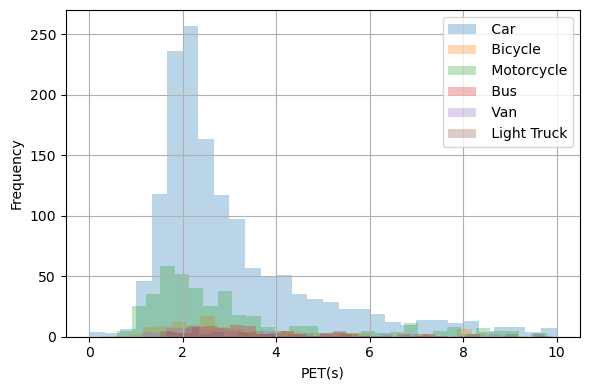

In [53]:
pet_data_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/LC/total_event/min_pet_event.csv"
Histogram_map_pet(pet_data_path)

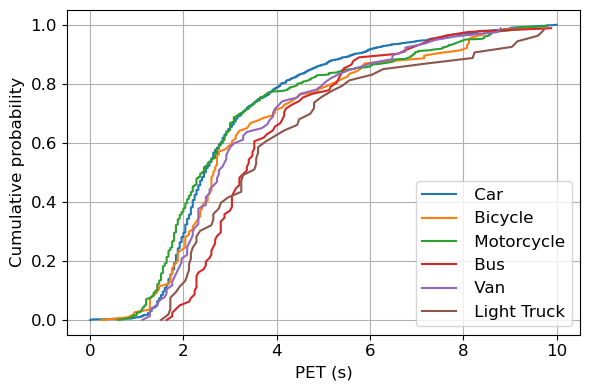

In [49]:
pet_data_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/LC/total_event/min_pet_event.csv"
Cumulative_curve_pet(pet_data_path)

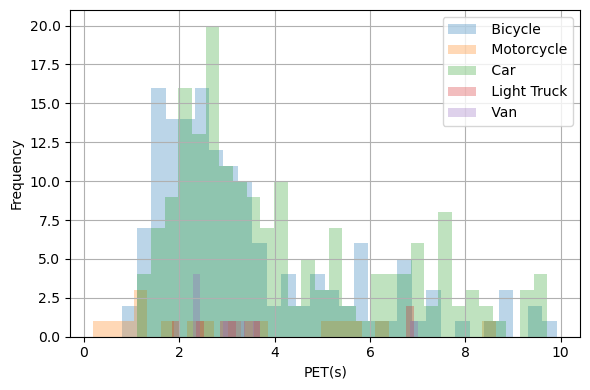

In [50]:
pet_data_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/total_event/min_pet_event.csv"
Histogram_map_pet(pet_data_path)

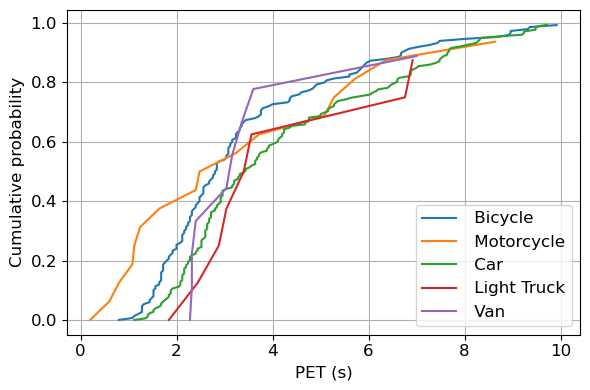

In [52]:
pet_data_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/total_event/min_pet_event.csv"
Cumulative_curve_pet(pet_data_path)

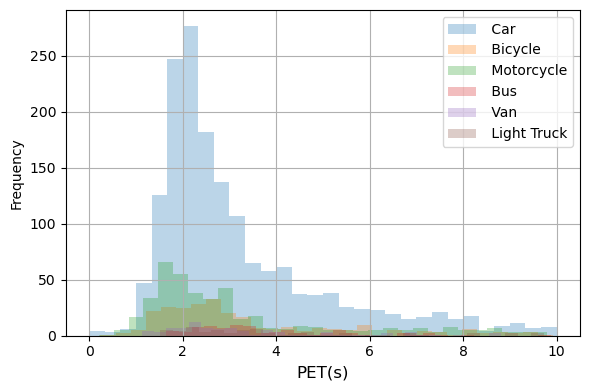

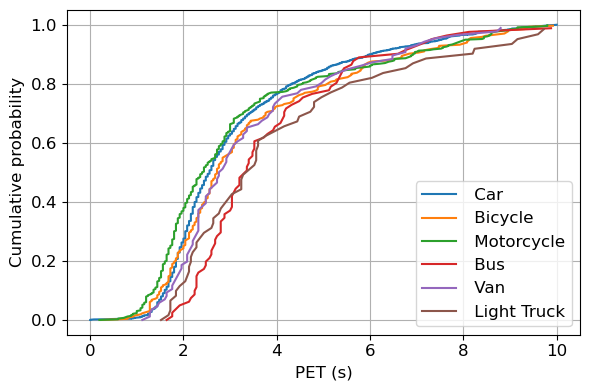

In [61]:
all_event_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/all_min_pet_event.csv"
Histogram_map_pet(all_event_path)
Cumulative_curve_pet(all_event_path)

## 合并两个交叉口的所有数据到一个表格中

In [57]:
def  Integration_data(Data1_path,Data2_path,save_path):
    data1 = pd.read_csv(Data1_path)
    df1  = pd.DataFrame(data1)
    data2 = pd.read_csv(Data2_path)
    df2 = pd.DataFrame(data2)
    df1['intersection_name'] = 'LC'
    df2['intersection_name'] = 'WN'
    df = pd.concat([df1,df2])
    df.to_csv(save_path, index=False, header=True)
    return

In [58]:
Data1_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/LC/total_event/min_pet_event.csv"
Data2_path =  r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/WN/total_event/min_pet_event.csv"
save_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/all_min_pet_event.csv"
Integration_data(Data1_path,Data2_path,save_path)

In [72]:
Data1_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/LC_conflict_event.csv"
Data2_path =  r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/WN_conflict_event.csv"
save_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/TTC/event_chain/all_TTC_event_chain.csv"
Integration_data(Data1_path,Data2_path,save_path)

### 显示PET冲突事件的分布

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from matplotlib import colors as c

#FUNCTION TO CALCULATE INTENSITY WITH QUARTIC KERNEL
def kde_quartic(d,h):
    dn=d/h
    P=(15/16)*(1-dn**2)**2
    return P

def Distrubition_of_pet_event(data_path,intersection_name,intersection_size):
    pet_location = pd.read_csv(pet_data_path)
    df = pd.DataFrame(pet_location)
    df = df[df['intersection_name']==str(intersection_name)]
    df = df[(df['F_world_x'] >= intersection_size[0]) & (df['F_world_x'] <=intersection_size[1])]
    df = df[(df['F_world_y'] >= intersection_size[2]) & (df['F_world_y'] <= intersection_size[3])]
    # redefine the row number of table
    df = df.reset_index(drop=True)
    x = df['F_world_x']
    y = df['F_world_y']
    #DEFINE GRID SIZE AND RADIUS(h)
    grid_size= 3
    h= 3

    #GETTING X,Y MIN AND MAX
    x_min=min(x)
    x_min = np.floor(x_min)
    x_max=max(x)
    x_max = np.ceil(x_max)
    y_min=min(y)
    y_min = np.floor(y_min)
    y_max=max(y)
    y_max = np.ceil(y_max)
     #CONSTRUCT GRID
    x_grid=np.arange(x_min-h,x_max+h,grid_size)
    y_grid=np.arange(y_min-h,y_max+h,grid_size)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)

    #GRID CENTER POINT
    xc=x_mesh+(grid_size/2)
    yc=y_mesh+(grid_size/2)    
    #PROCESSING
    intensity_list=[]
    for j in range(len(xc)):
        intensity_row=[]
        for k in range(len(xc[0])):
            kde_value_list=[]
            for i in range(len(x)):
                # print(j,i)
                #CALCULATE DISTANCE
                d=math.sqrt((xc[j][k]-x[i])**2+(yc[j][k]-y[i])**2)
                if d<=h:
                    p=kde_quartic(d,h)
                else:
                    p=0
                kde_value_list.append(p)
            #SUM ALL INTENSITY VALUE
            p_total=sum(kde_value_list)
            intensity_row.append(p_total)
        intensity_list.append(intensity_row)

    #HEATMAP OUTPUT
    intensity=np.array(intensity_list)
    plt.pcolormesh(x_mesh,y_mesh,intensity)
    plt.plot(x,y,'ro',markersize=2)
    plt.xlabel('X (m)')
    plt.xlabel('Y (m)')
    plt.colorbar()
    plt.show()

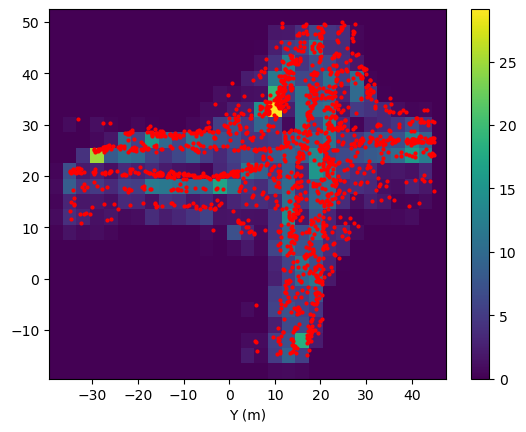

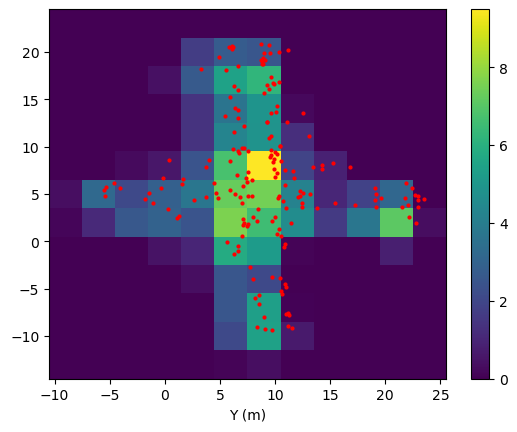

In [70]:
pet_data_path = r'E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/PET/all_min_pet_event.csv'
# longchang road
intersection_name = 'LC'
intersection_size = [-35,45,-15,50]
Distrubition_of_pet_event(pet_data_path,intersection_name,intersection_size)
# ningwu road
intersection_name_wn = 'WN'
intersection_size_wn = [-6,24,-10,21]
Distrubition_of_pet_event(pet_data_path,intersection_name_wn,intersection_size_wn)

### 重新提取TTC中的事件，定义变量

In [ ]:
# 根据PET来提取TTC事件链中提取车辆的碰撞交互事件
def Extract_ttc_event_chain(PET_event_path,TTC_chain_path,colum_name,save_path):
    pet_ttc_event = pd.DataFrame(columns=colum_name)
    pet_event = pd.read_csv(PET_event_path)
    pet_event = pd.DataFrame(pet_event)
    TTC_chain = pd.read_csv(TTC_chain_path)
    TTC_chain = pd.DataFrame(TTC_chain)
    pet_event_pair = pet_event[['intersection_name','Video_id','F_vehicle_id','S_vehicle_id','postive_PET']]
    intersection_nums = pd.unique(pet_event_pair['intersection_name'])
    for inters_id in intersection_nums:
        in_pet_event = pet_event_pair[pet_event_pair['intersection_name']==str(inters_id)]
        in_ttc_event = TTC_chain[TTC_chain['intersection_name']==str(inters_id)]
        Video_id_pet_nums = pd.unique(in_pet_event['Video_id'])
        for vid in Video_id_pet_nums:
            pet_int_vid = in_pet_event[in_pet_event['Video_id']==str(vid)]
            ttc_int_vid = in_ttc_event[in_ttc_event['Video_id']==str(vid)]
            pet_pair_nums = pet_int_vid[['F_vehicle_id','S_vehicle_id']]
            pet_pair_nums = pet_pair_nums.values.tolist()
            for pairid in pet_pair_nums:
                A = pairid[0]
                B = pairid[1]
                ttc_event_pair_id = ttc_int_vid[(ttc_int_vid['F_id']==A) & (ttc_int_vid['S_id'] == B)]
                pet_event_pairid = pet_int_vid[(pet_int_vid['F_vehicle_id']==pairid[0]) & (pet_int_vid['F_vehicle_id']==pairid[0])]
                pet_value = pet_event_pairid['postive_PET'].iloc[0]
                if len(ttc_event_pair_id)>0:
                    ttc_event_pair_id['PET'] = pet_value
                    pet_ttc_event = pd.concat([pet_ttc_event,ttc_event_pair_id])
    pet_ttc_event.to_csv(save_path, index=False, header=True)
    return pet_ttc_event

In [ ]:
colum_name = ['intersection_name','Video_id','frame_time','F_id', 'F_type', 'F_world_x', 'F_world_y', 'F_speed', 'F_acc','F_jerk', 'F_Angle','F_dir','S_id', 'S_type','S_dir','S_world_x','S_world_y', 'S_speed', 'S_acc','S_jerk', 'S_Angle', 'F_to_c','S_to_c','F_to_S','V_F_S','ACC_F_S','Ang_F_S','conflict_x','conflict_y','TTC','PET']
pet_event_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/all_min_pet_event.csv"
ttc_event_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/all_TTC_event_chain.csv"
pct_ttc_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/pet_ttc_event_chain.csv"
# save_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/pet_ttc_event.csv"
Extract_ttc_event_chain(pet_event_path,ttc_event_path,colum_name,pct_ttc_path)

#### 提取25%，50%，75% 分位数的变量

In [ ]:
def Extract_percentage_montion(data_path,colum_name,Save_path,percentage):
    data = pd.read_csv(data_path)
    lc_nums = pd.unique(data['intersection_name'])
    pet_ttc_event_25 = pd.DataFrame(columns=colum_name)
    for lc_id in lc_nums:
        lc_data = data[data['intersection_name']==str(lc_id)]
        vid_nums = pd.unique(lc_data['Video_id'])
        for vid in vid_nums:
            vid_lc_data = lc_data[lc_data['Video_id']==vid]
            pairs_nums = vid_lc_data[['F_id','S_id']]
            pairs_nums = pairs_nums.drop_duplicates()
            pairs_nums = pairs_nums.values.tolist()
            for pair_id in pairs_nums:
                print(pair_id)
                pair_id_event = vid_lc_data[(vid_lc_data['F_id']==pair_id[0])&(vid_lc_data['S_id']==pair_id[1])]
                # 过滤NaN值
                pair_id_event_ttc = pair_id_event[pair_id_event['TTC'].notnull()]
                # 计算非NaN值的25%位数值
                quantile_value = pair_id_event_ttc['TTC'].quantile(percentage)
                # 使用布尔索引过滤DataFrame
                pair_id_event_25_o = pair_id_event[pair_id_event['TTC'] <= quantile_value]
                pair_id_event_25_or = pair_id_event_25_o.sort_values(by='TTC')
                pair_id_event_25 = pair_id_event_25_or.iloc[-1]
                df = pd.DataFrame(pair_id_event_25)
                pair_id_event_25 = df.T
                pet_ttc_event_25 = pd.concat([pet_ttc_event_25, pair_id_event_25])
    pet_ttc_event_25.to_csv(Save_path, index=False, header=True)
    return pet_ttc_event_25

In [ ]:
colum_name = ['intersection_name','Video_id','frame_time','F_id', 'F_type', 'F_world_x', 'F_world_y', 'F_speed', 'F_acc','F_jerk', 'F_Angle','F_dir','S_id', 'S_type','S_dir','S_world_x','S_world_y', 'S_speed', 'S_acc','S_jerk', 'S_Angle', 'F_to_c','S_to_c','F_to_S','V_F_S','ACC_F_S','Ang_F_S','conflict_x','conflict_y','TTC','PET']
pet_event_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/all_min_pet_event.csv"
ttc_event_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/all_TTC_event_chain.csv"
pct_ttc_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/pet_ttc_event_chain.csv"
save_path = r"E:/CodeResource/000_Traffic_conflict_risk_analysis/Data_clearning/Data_set/New_gaps_second_data/New_data_conflict_0.12_event/conflict_event/pet_ttc_event_75.csv"
percentage = 75
Extract_percentage_montion(pct_ttc_path,colum_name,save_path,percentage)

####  绘制变量的正太分布图

In [2]:
import pandas as pd
data = pd.read_csv(r'E:\CodeResource\000_Traffic_conflict_risk_analysis\Data_clearning\Data_set\New_gaps_second_data\New_data_conflict_0.12_event\conflict_event/pet_ttc_event_15.csv', delimiter=',')

,intersection_name,Video_id,frame_time,F_id,F_type,F_world_x,F_world_y,F_speed,F_acc,F_jerk,...,F_to_c,S_to_c,F_to_S,V_F_S,ACC_F_S,Ang_F_S,conflict_x,conflict_y,TTC,PET
0,LC,_C0004,13.28,23,Car,13.798689,28.650887,6.679027,2.059791,10.097896,...,8.179634,5.410928,13.007290,4.681198,2.094892,16.084035,8.688738,22.263806,1.318663,2.04
1,LC,_C0004,67.60,141,Car,17.069760,8.270712,5.142123,2.115201,3.229142,...,9.183255,2.883759,11.980412,1.654459,3.168599,19.168394,18.636925,17.319258,1.760824,1.92
2,LC,_C0004,76.04,167,Car,12.927967,4.629923,5.805479,0.997128,6.291021,...,13.343488,2.894581,10.851725,10.758694,4.701045,25.577409,13.994740,17.930700,2.398691,2.04
3,LC,_C0004,83.80,206,Car,14.310757,40.250586,3.524335,1.655448,2.268198,...,3.685932,4.477462,7.865016,2.232495,2.463780,1.378065,16.032960,43.509436,1.205109,1.80
4,LC,_C0004,240.72,533,Car,24.501590,22.579602,3.614437,2.187037,7.297392,...,3.803522,5.889653,9.567658,1.215297,0.607739,6.358996,27.945325,24.194368,1.678381,2.64


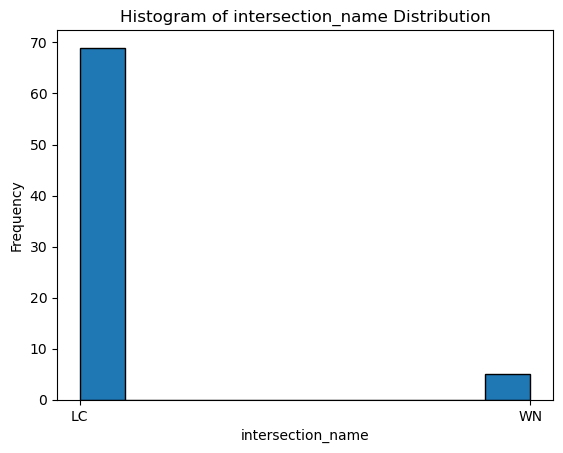

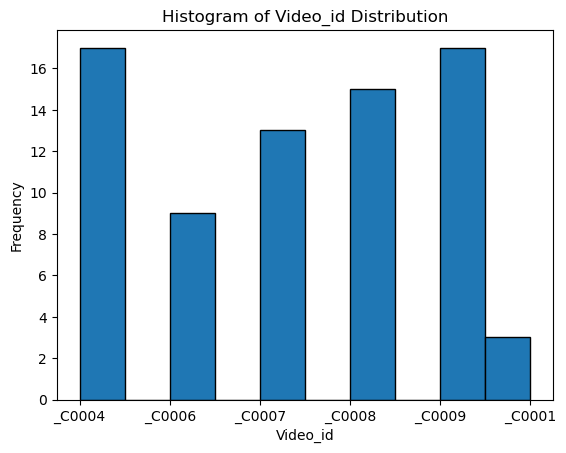

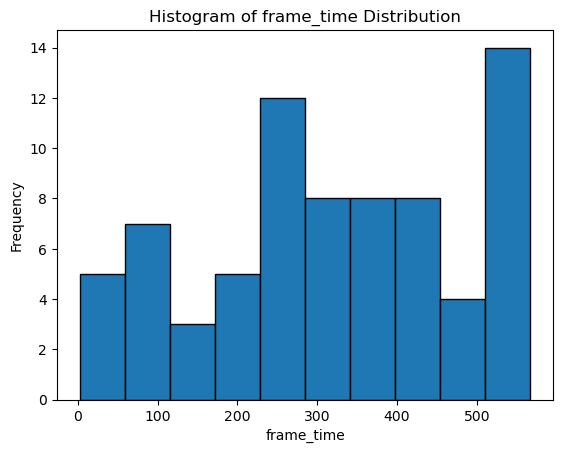

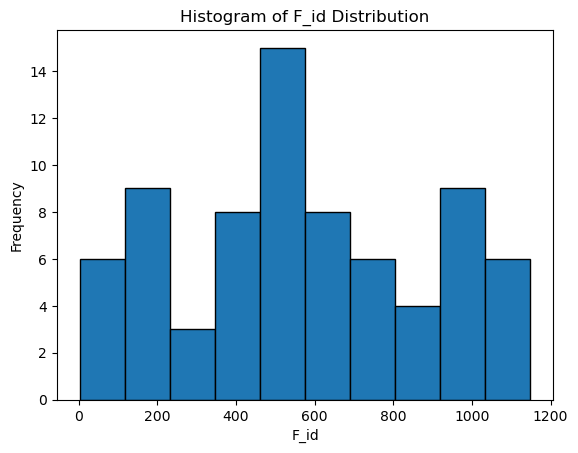

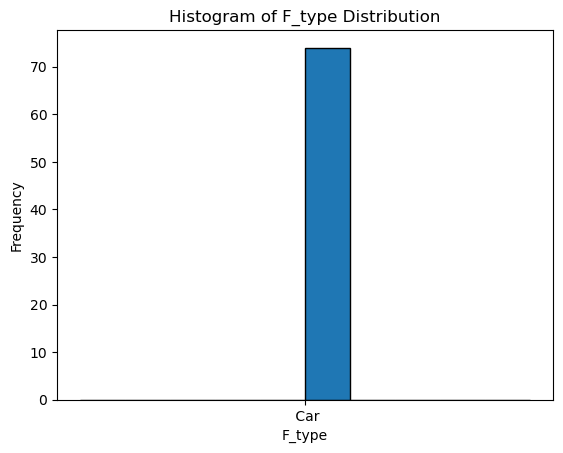

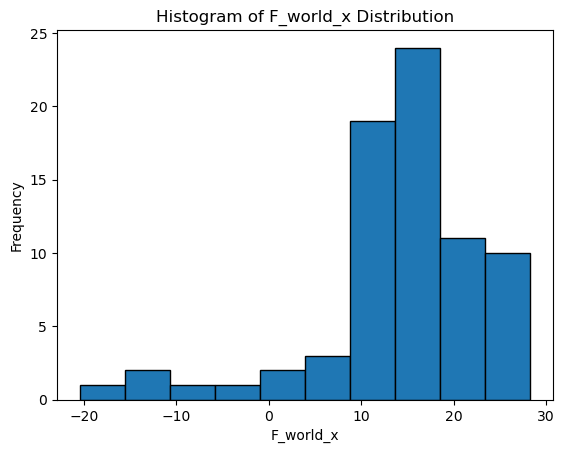

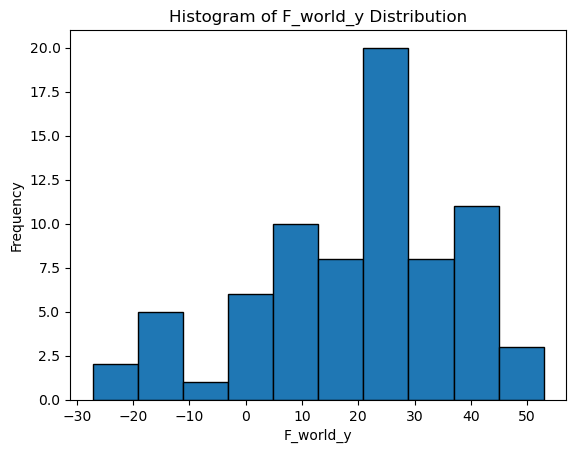

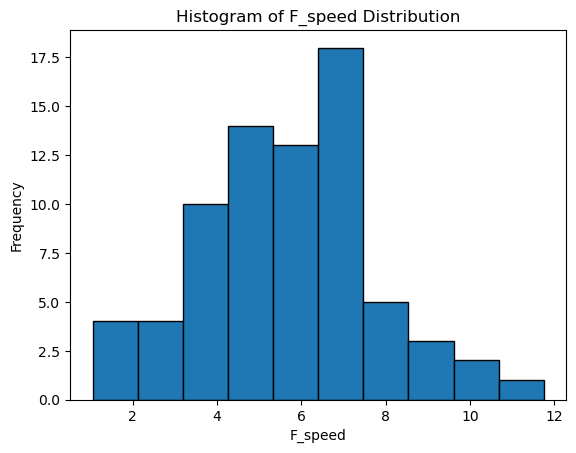

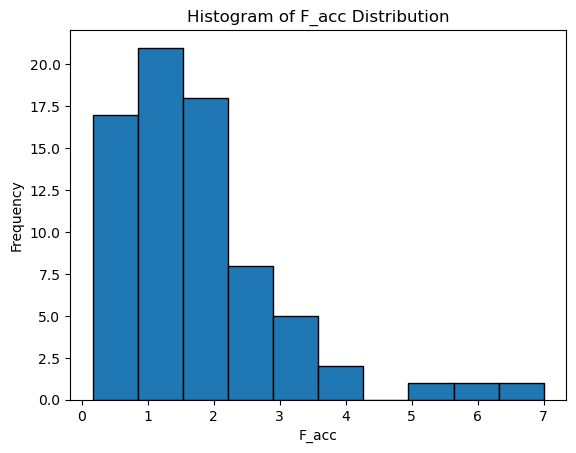

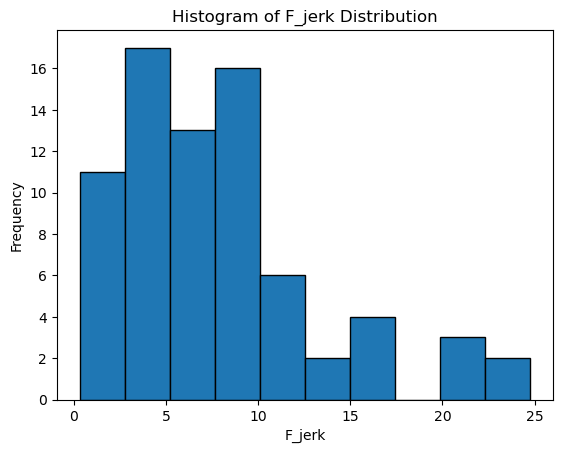

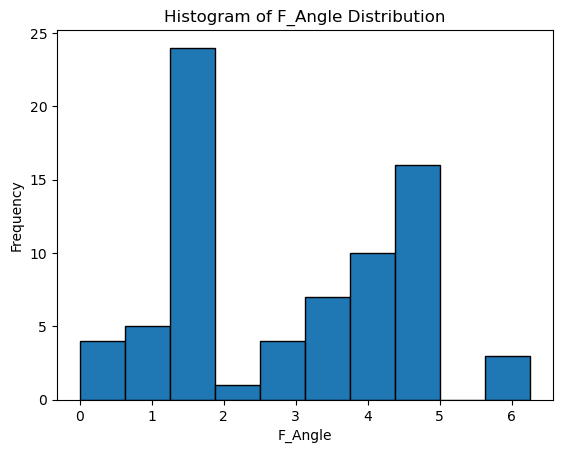

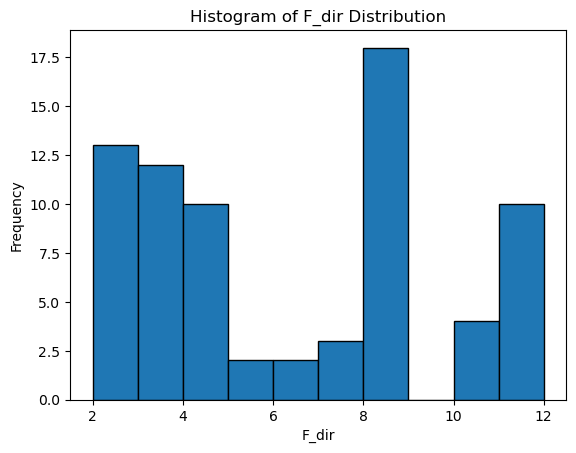

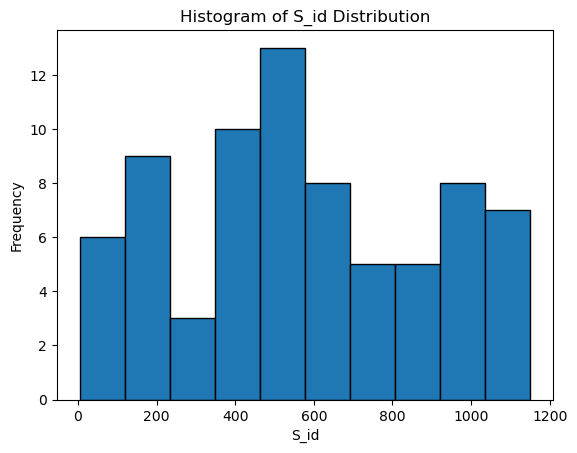

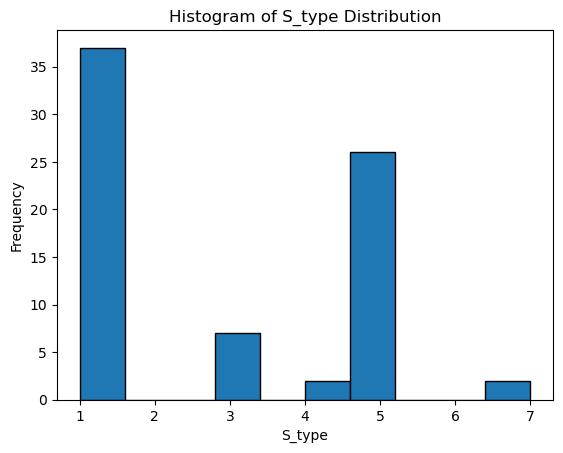

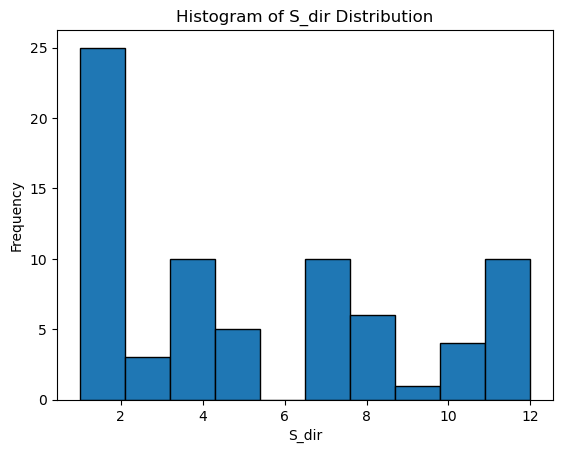

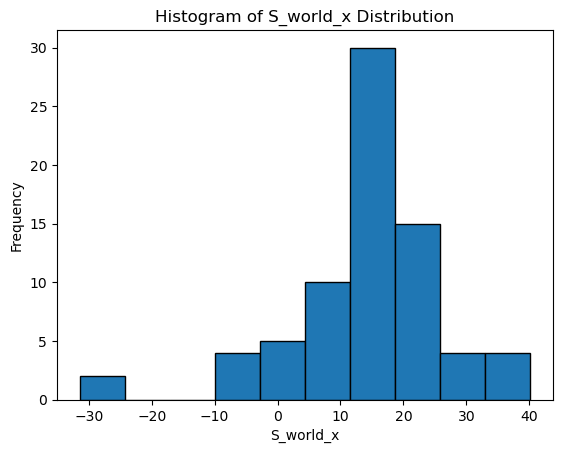

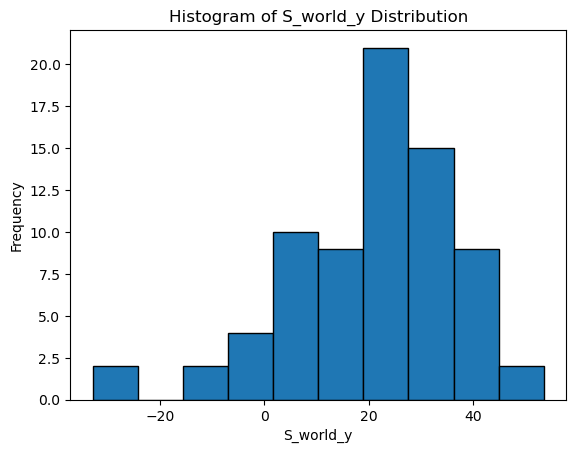

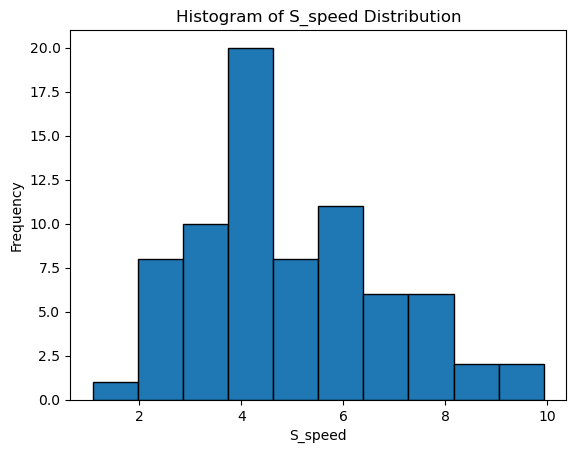

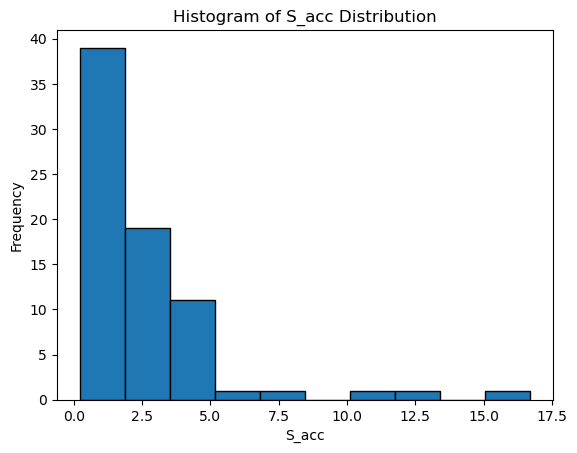

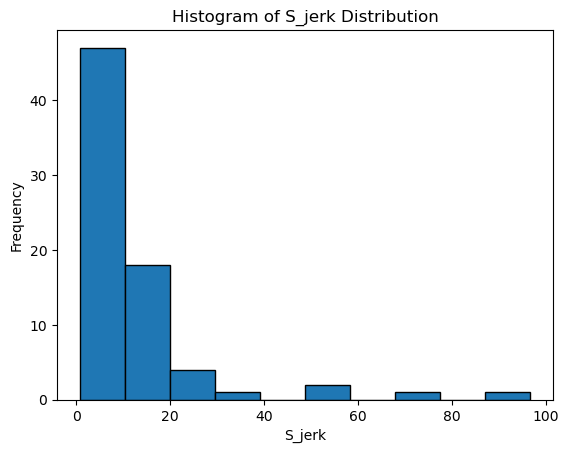

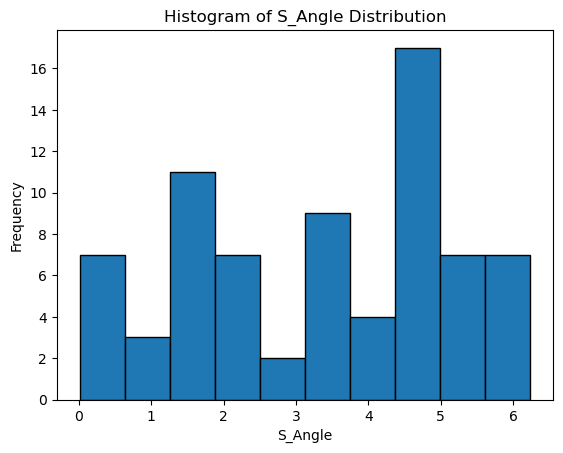

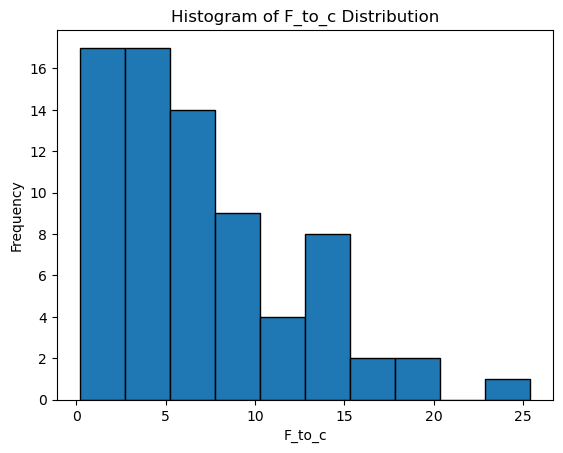

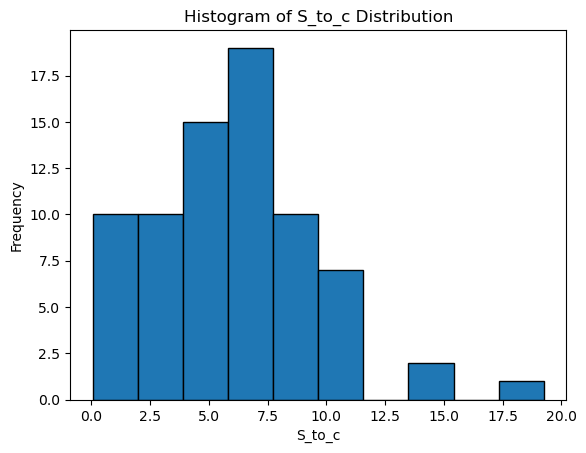

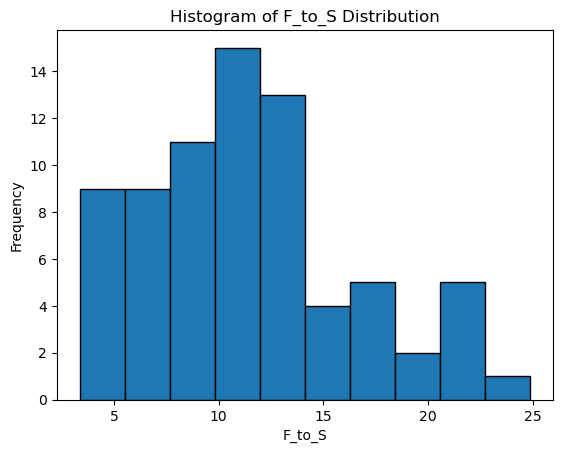

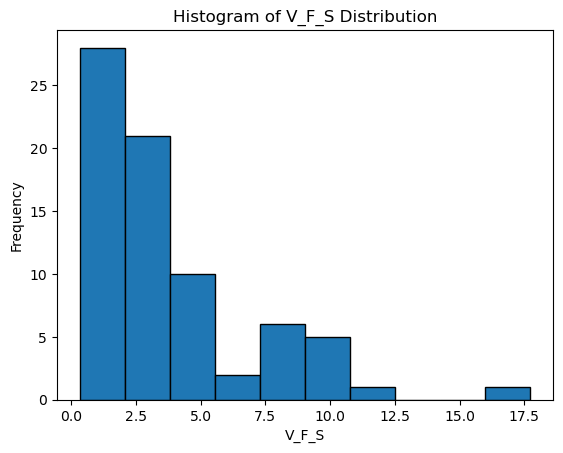

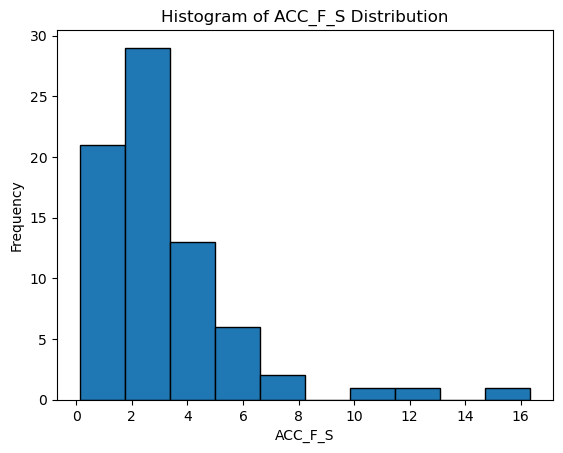

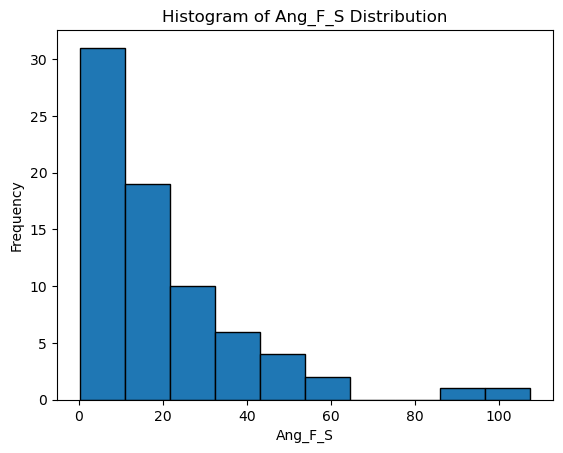

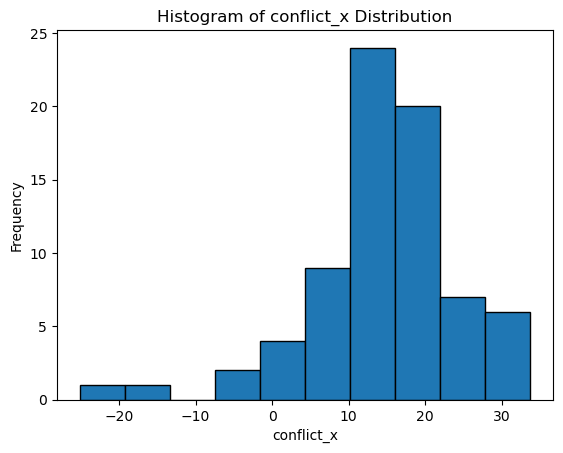

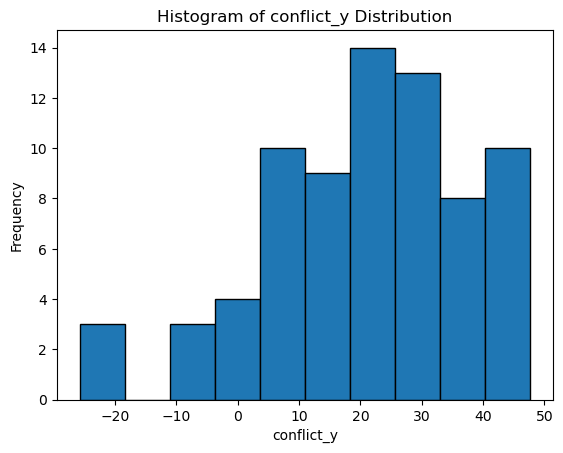

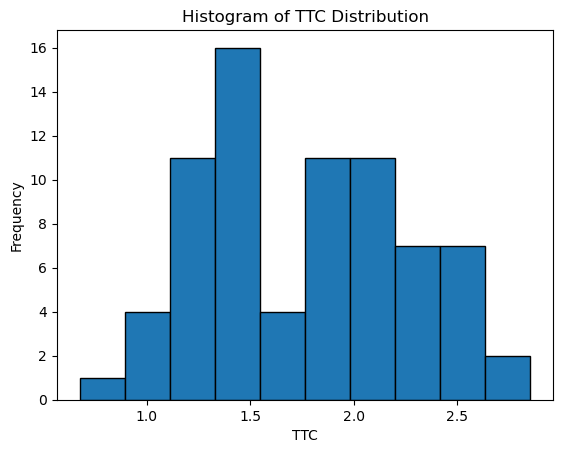

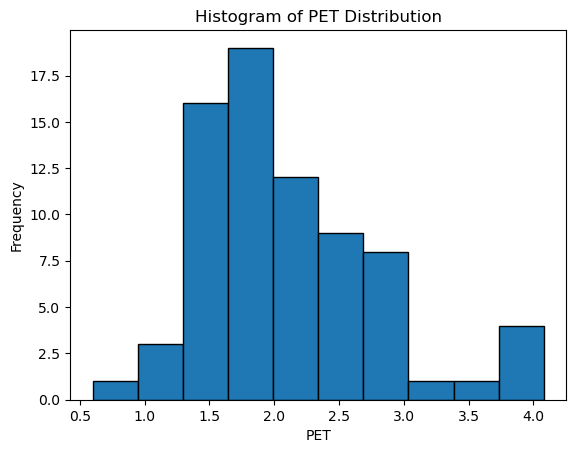

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 生成随机数据作为示例

import pandas as pd
import matplotlib.pyplot as plt

# 创建一个示例DataFrame
df = pd.DataFrame(data)

# 遍历每一列并绘制直方图
for column in df.columns:
    plt.hist(df[column], bins=10, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column} Distribution')
    plt.show()

In [11]:
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
# dele
#  speed_mean
# first vehicle
df.loc[df['F_speed'] <= 5, 'F_speed'] = 1
df.loc[(df['F_speed'] >5)&(df['F_speed'] <= 10), 'F_speed'] = 2
df.loc[(df['F_speed'] >10), 'F_speed'] = 3
# second vehicle
df.loc[df['F_acc'] <= 2, 'F_acc'] = 1
df.loc[(df['F_acc'] >2)&(df['F_acc'] <= 4), 'F_acc'] = 2
df.loc[df['F_acc'] > 4, 'F_acc'] = 3
# relative
df.loc[df['F_jerk'] <= 10, 'F_jerk'] = 1
df.loc[(df['F_jerk'] >10)&(df['F_jerk'] <= 20), 'F_jerk'] = 2
df.loc[df['F_jerk'] > 20, 'F_jerk'] = 3

df.loc[df['F_Angle'] <= 2.5, 'F_Angle'] = 1
df.loc[(df['F_Angle'] >2.5)&(df['F_Angle'] <= 5), 'F_Angle'] = 2
df.loc[df['F_Angle'] > 5, 'F_Angle'] = 3

# first vehicle
df.loc[df['S_speed'] <= 5, 'S_speed'] = 1
df.loc[(df['S_speed'] >5)&(df['S_speed'] <= 10), 'S_speed'] = 2
df.loc[(df['S_speed'] >10), 'S_speed'] = 3
# second vehicle
df.loc[df['S_acc'] <= 2, 'S_acc'] = 1
df.loc[(df['S_acc'] >2)&(df['S_acc'] <= 4), 'S_acc'] = 2
df.loc[df['S_acc'] > 4, 'S_acc'] = 3
# relative
df.loc[df['S_jerk'] <= 10, 'S_jerk'] = 1
df.loc[(df['S_jerk'] >10)&(df['S_jerk'] <= 20), 'S_jerk'] = 2
df.loc[df['S_jerk'] > 20, 'S_jerk'] = 3

df.loc[df['S_Angle'] <= 2.5, 'S_Angle'] = 1
df.loc[(df['S_Angle'] >2.5)&(df['S_Angle'] <= 5), 'S_Angle'] = 2
df.loc[df['S_Angle'] > 5, 'S_Angle'] = 3

#  acc _mean
# first vehicle
df.loc[df['F_to_c'] <= 5, 'F_to_c'] = 1
df.loc[(df['F_to_c'] >5)&(df['F_to_c'] <= 10), 'F_to_c'] = 2
df.loc[(df['F_to_c'] >10)&(df['F_to_c'] <= 15), 'F_to_c'] = 3
df.loc[(df['F_to_c'] >15)&(df['F_to_c'] <= 20), 'F_to_c'] = 4
df.loc[df['F_to_c'] > 20, 'F_to_c'] = 5

df.loc[df['S_to_c'] <= 5, 'S_to_c'] = 1
df.loc[(df['S_to_c'] >5)&(df['S_to_c'] <= 10), 'S_to_c'] = 2
df.loc[(df['S_to_c'] >10)&(df['S_to_c'] <= 15), 'S_to_c'] = 3
df.loc[(df['S_to_c'] >15)&(df['S_to_c'] <= 20), 'S_to_c'] = 4
df.loc[df['S_to_c'] > 20, 'S_to_c'] = 5


df.loc[df['F_to_S'] <= 5, 'F_to_S'] = 1
df.loc[(df['F_to_S'] >5)&(df['F_to_S'] <= 10), 'F_to_S'] = 2
df.loc[(df['F_to_S'] >10)&(df['F_to_S'] <= 15), 'F_to_S'] = 3
df.loc[(df['F_to_S'] >15)&(df['F_to_S'] <= 20), 'F_to_S'] = 4
df.loc[df['F_to_S'] > 20, 'F_to_S'] = 5

df.loc[df['V_F_S'] <= 5, 'V_F_S'] = 1
df.loc[(df['V_F_S'] >5)&(df['V_F_S'] <= 10), 'V_F_S'] = 2
df.loc[(df['V_F_S'] >10)&(df['V_F_S'] <= 15), 'V_F_S'] = 3
df.loc[(df['V_F_S'] >15)&(df['V_F_S'] <= 20), 'V_F_S'] = 4
df.loc[df['V_F_S'] > 20, 'V_F_S'] = 5

df.loc[df['ACC_F_S'] <= 5, 'ACC_F_S'] = 1
df.loc[(df['ACC_F_S'] >5)&(df['ACC_F_S'] <= 10), 'ACC_F_S'] = 2
df.loc[(df['ACC_F_S'] >10)&(df['ACC_F_S'] <= 15), 'ACC_F_S'] = 3
df.loc[(df['ACC_F_S'] >15)&(df['ACC_F_S'] <= 20), 'ACC_F_S'] = 4
df.loc[df['ACC_F_S'] > 20, 'ACC_F_S'] = 5

df.loc[df['Ang_F_S'] <= 30, 'Ang_F_S'] = 1
df.loc[(df['Ang_F_S'] >30)&(df['Ang_F_S'] <= 60), 'Ang_F_S'] = 2
df.loc[(df['Ang_F_S'] >60)&(df['Ang_F_S'] <= 90), 'Ang_F_S'] = 3
df.loc[df['Ang_F_S'] > 90, 'Ang_F_S'] = 4

df = pd.DataFrame(df)